In [1]:
import pandas as pd

data_train = pd.read_csv('/Users/vladamalkina/Downloads/train_spam.csv')
data_test = pd.read_csv('/Users/vladamalkina/Downloads/test_spam.csv')

### выведем первые 5 строчек датасетов

In [2]:
display(data_train.head())

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [3]:
display(data_test.head())

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


### выведем общую информацию

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4070 non-null   object
dtypes: object(1)
memory usage: 31.9+ KB


### размеры датасетов

In [6]:
data_train.shape

(16278, 2)

In [7]:
data_test.shape

(4070, 1)

### Распределение target:

ham     0.704571
spam    0.295429
Name: text_type, dtype: float64


<AxesSubplot:>

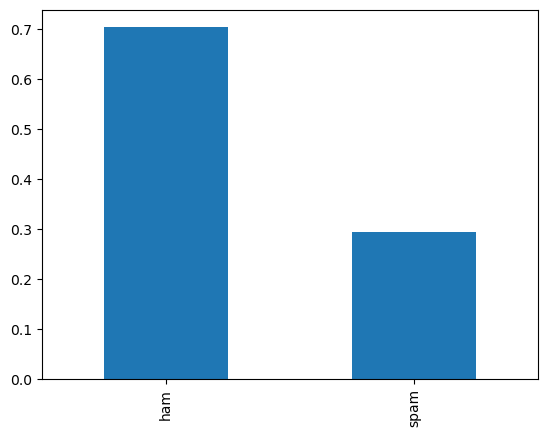

In [8]:
class_frequency = data_train['text_type'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind='bar')

### Очистка текста:

In [9]:
import re

In [10]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.split()
    text = " ".join(text)
    return text

In [11]:
data_train['lemm_text'] = data_train['text'].apply(clear_text)
data_train.head()

,text_type,text,lemm_text
0,ham,make sure alex knows his birthday is over in f...,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...,overview of hr associates analyst project per ...


In [12]:
data_test['lemm_text'] = data_test['text'].apply(clear_text)
data_test.head()

,text,lemm_text
0,j jim whitehead ejw cse ucsc edu writes j you ...,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...,underpriced issue with high return on equity t...


### Лемматизация текста:

In [13]:
import spacy
import en_core_web_sm

In [14]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [15]:
def lemmatize(text):
    lemm_list = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in lemm_list])
    return lemm_text

In [16]:
data_train['lemm_text'] = data_train['lemm_text'].apply(lemmatize)
data_train['lemm_text'].head()

0    make sure alex know his birthday be over in fi...
1    a resume for john lavorato thanks vince I will...
2    plzz visit my website moviesgodml to get all m...
3    urgent your mobile number have be award with a...
4    overview of hr associates analyst project per ...
Name: lemm_text, dtype: object

In [17]:
data_test['lemm_text'] = data_test['lemm_text'].apply(lemmatize)
data_test['lemm_text'].head()

0    j jim whitehead ejw cse ucsc edu write j you o...
1    original message from bitbitch magnesium net p...
2    java for manager vince durasoft who just teach...
3                  there be a youtuber name saiman say
4    underprice issue with high return on equity th...
Name: lemm_text, dtype: object

### разделим features и target

In [18]:
X = data_train.drop(columns = ['text_type', 'text'])
y = data_train['text_type']

### разделим данные на тренировочную и валидационную выборки

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

### Вычисление TF-IDF для корпуса текстов:

In [20]:
corpus_train = X_train['lemm_text']
corpus_valid = X_val['lemm_text']
corpus_test = data_test['lemm_text']

In [21]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
count_tf_idf = TfidfVectorizer()

In [22]:
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test)

In [23]:
print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_valid.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (12208, 31517)
Размер матрицы: (4070, 31517)
Размер матрицы: (4070, 31517)


### обучение моделей

#### logistic regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

In [25]:
parametrs = { "C" : np.logspace(-3,3,7), "penalty" : ["l1","l2"], "class_weight" : ["auto", "balanced"]}
log_reg = LogisticRegression()
grid_log_reg = GridSearchCV(log_reg, parametrs, cv=5)
grid_log_reg.fit(tf_idf_train, y_train)
grid_log_reg.best_params_

{'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2'}

In [26]:
model_log_reg = LogisticRegression(C = 1.0, class_weight = 'balanced', penalty = 'l2') 
model_log_reg.fit(tf_idf_train, y_train)
predicted_valid =  model_log_reg.predict(tf_idf_valid)

In [27]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_val = labelencoder.fit_transform(y_val)

In [28]:
from sklearn.metrics import roc_auc_score
predicted_valid = labelencoder.transform(predicted_valid)
print("ROC-AUC мера наилучшей модели на валидационной выборке:", roc_auc_score(y_val, predicted_valid))

ROC-AUC мера наилучшей модели на валидационной выборке: 0.9000497619167432


#### random forest classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
parametrs = { 'n_estimators': range (1, 10, 1), 'max_depth': range (1, 10, 1)}
rand_for_clas = RandomForestClassifier()
grid_rand_for_clas = GridSearchCV(rand_for_clas, parametrs, cv=5)
grid_rand_for_clas.fit(tf_idf_train, y_train)
grid_rand_for_clas.best_params_

{'max_depth': 9, 'n_estimators': 5}

In [31]:
model_rand_for_clas = RandomForestClassifier(n_estimators = 3, max_depth = 9)
model_rand_for_clas.fit(tf_idf_train, y_train)
predicted_valid = model_rand_for_clas.predict(tf_idf_valid)

In [32]:
predicted_valid = labelencoder.transform(predicted_valid)
print("ROC-AUC мера наилучшей модели на валидационной выборке:", roc_auc_score(y_val, predicted_valid))

ROC-AUC мера наилучшей модели на валидационной выборке: 0.5967082094803073


#### decision tree classifier

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
parametrs = { 'criterion': ['gini','entropy'],
             'max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
dec_tre_clas = DecisionTreeClassifier()
grid_dec_tre_clas = GridSearchCV(dec_tre_clas, parametrs, cv=5)
grid_dec_tre_clas.fit(tf_idf_train, y_train)
grid_dec_tre_clas.best_params_

{'criterion': 'gini', 'max_depth': 120}

In [35]:
model_dec_tre_clas = DecisionTreeClassifier(criterion = 'gini', max_depth = 50)
model_dec_tre_clas.fit(tf_idf_train, y_train)
predicted_valid = model_dec_tre_clas.predict(tf_idf_valid)

In [36]:
predicted_valid = labelencoder.transform(predicted_valid)
print("ROC-AUC мера наилучшей модели на валидационной выборке:", roc_auc_score(y_val, predicted_valid))

ROC-AUC мера наилучшей модели на валидационной выборке: 0.829588977161605


logistic regression = 0.9000497619167432

random forest classifier = 0.596839014755247

decision tree classifier = 0.8278839473235828

### модель с наибольшим значением roc_auc метрики - logistic regression

#### тестирование модели:

In [37]:
preds = model_log_reg.predict(tf_idf_test)

### запишем предсказания модели в файл

In [38]:
data_test = data_test.drop(columns = ['lemm_text'])
data_test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [39]:
data_test['score'] = preds
data_test.head()

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,ham
1,original message from bitbitch magnesium net p...,ham
2,java for managers vince durasoft who just taug...,ham
3,there is a youtuber name saiman says,ham
4,underpriced issue with high return on equity t...,spam


In [40]:
data_test.to_csv('test_spam_new.csv', index=False)